In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
files = '~/Documents/NSERC/files/'

In [3]:
def read(filename, mimic, folder=None):
    if mimic:
        if folder is None:
            raise ValueError('Enter Folder')
        files = '~/Documents/NSERC/mimic-iv-2.2/'+folder+'/extracted_csvs/'
    else:
        files = '~/Documents/NSERC/files/'
    file = pd.read_csv(files+filename+'.csv')
    if 'Unnamed: 0' in file.columns:
        file = file.drop('Unnamed: 0', axis=1)
    return file 

In [4]:
def readc(filename):
    file = pd.read_csv(files+'consults/'+filename+'.csv')
    if 'Unnamed: 0' in file.columns:
        file = file.drop('Unnamed: 0', axis=1)
    return file 

In [5]:
icu = read('icu_results', False)
ed = read('ed_timedata', False)
neuro = read('neuro_ward_timedata', False)
false = read('just_neuro', False)
icu_neuro = read('after', False)

In [70]:
ocu = readc('occupational_therapy')
pt = readc('physio_therapy')
ng_pt = readc('negative_physio')
sw = readc('social_work')
nutri = read('consults/stroke_consults2', False)
nutri= nutri[nutri['order_subtype'].str.startswith('Nutrition')]

# Synthetic Stroke Data – Mimic Analysis

### Histograms:
- Length of stay in ICU
- Length of stay in Emergency Department
- Length of stay in Neurology Ward
- Admission time to CT Scan
- Admission time to TPA
- Admission time to ICU
- Admission time to Neurology Ward/ICU to Neurology Ward
- Admission time to all Specialists
    - Physiotherapist
    - Occupational Therapist
    - Social Worker
    - Dietitian
    - Cardiologist
    - Neurologist
    - Speech Language Pathologist
 

### My process in creating these distributions is as follows,

<strong>1. Splitting the data into manageable sections</strong>

For each of the distributions to be the most accurate, data was often split into 2, 3 or 4, sections depending on shape/location of peaks in the data. As well, any outliers with values way higher then average, as well as some negative values. For any stay times negatives were removed due to a clear recording error. For treatment times, negative values can be included depending on the distribution. Physiotherapy time for example, includes negative values from ED patients (ie patients in were in the Emergency Department at the time of their consult) but discards ones from non ED patients (whose whereabouts are unaccounted for within the data set). Not only does shortening sections make the distributions appear better, the differences can clearly be seen when implemented into the model.

<strong>2. Fitting the data</strong>

Each distribution was fitted to either a normal, skewed normal, or gamma distribution. Using scipy stats fit method, a pdf line was made of each section of data.

<strong>3. Applying results to the model</strong>

When a patient is in need of a certain treatment, they sample from one of the distribution sections relevant to that treatment. In the case of split distributions, the distribution is chosen based on the percent of patients in the real data who are apart of that distribution. For example, if a treatment was split into two sections, one holding 70% of the patients and the other 30%, then 70% of patient assigned to that treatment would sample from the first distribution, and the remaining 30% to the second. In cases where outliers were removed, their percent is incorporated into the nearest distribution. These assigned times give patients a rough estimate of when they need to recieve the treatment, but these times fluctuate and update themselves based on hospital busyness, time of day, and other treatments. 

## Length of stay in ICU

[Text(0.5, 1.0, 'icu time')]

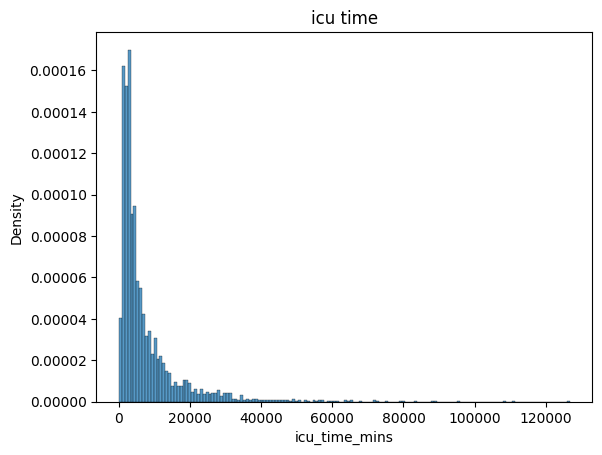

In [7]:
sns.histplot(x='icu_time_mins',data=icu, stat='density').set(title='icu time')

Data was broken into 3 sections for more accurate distributions:
- 0-2400 minutes
- 2400-20000 minutes
- 20000-80000 minutes
  
When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Each time is measured by a patient’s ICU out time and ICU in time. 

### From 0 to 2400 minutes:
Models the early peak in minutes

<Axes: title={'center': 'icu time: 0 to 2400'}, xlabel='icu_time_mins', ylabel='Density'>

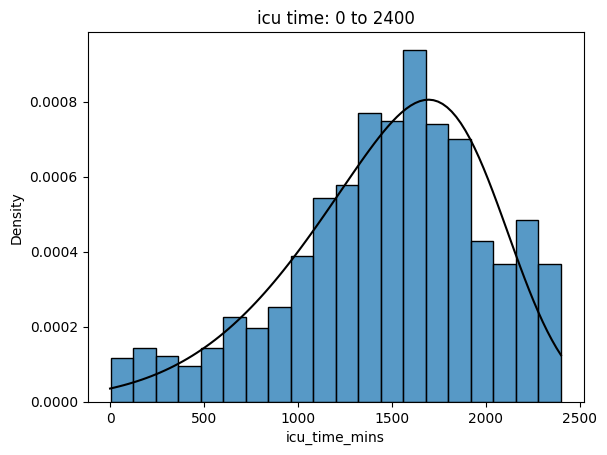

In [8]:
x = np.linspace(0, 2400, 100)

data=icu[icu['icu_time_mins']<2400]

a,loc, scale = stats.skewnorm.fit(data['icu_time_mins'])

sns.histplot(x='icu_time_mins',data=data, stat='density').set(title='icu time: 0 to 2400')
sns.lineplot(x=x, y=stats.skewnorm.pdf(x,a, loc, scale), color='black')

- Graphed using a skewnorm distribution
- a = -2.82
- loc = 2085
- scale = 805.6
- ­Out of all stroke patient ICU stays, this distribution includes 28.5% of them.

### From 2400 minutes to 20000 minutes:
Models the main peak and descent

<Axes: title={'center': 'icu time: 2400 to 20000'}, xlabel='icu_time_mins', ylabel='Density'>

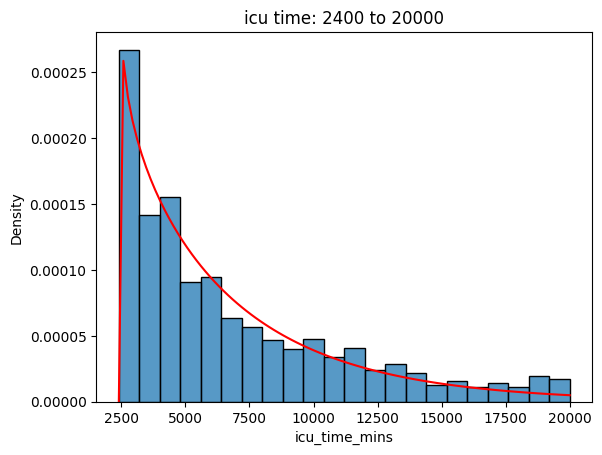

In [9]:
x2 = np.linspace(2400, 20000, 100)

data2=icu[icu['icu_time_mins']>=2400]
data2=data2[data2['icu_time_mins']<20000]

a2,loc2, scale2 = stats.gamma.fit(data2['icu_time_mins'])

sns.histplot(x='icu_time_mins',data=data2, stat='density').set(title='icu time: 2400 to 20000')
sns.lineplot(x=x2,y=stats.gamma.pdf(x2, a2, loc2,scale2), color='red')

- Graphed using a gamma distribution.
- a = 0.891
- loc = 2404.5
- scale = 5009.6
- Out of all stroke patient ICU stays, this distribution includes 63.8% of them.

### From 20000 minutes to 80000 minutes:
Models the rest of small values as the frequency of values begins to drop off

<Axes: title={'center': 'icu time: 2000 to 80000'}, xlabel='icu_time_mins', ylabel='Density'>

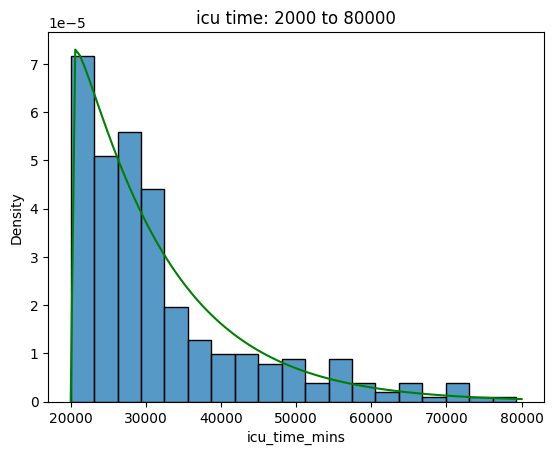

In [10]:
x3 = np.linspace(20000,80000, 100)
data3 = icu[icu['icu_time_mins']>=20000]
data3 = data3[data3['icu_time_mins']<80000]
a3, loc3, scale3 = stats.gamma.fit(data3['icu_time_mins'])
sns.histplot(x='icu_time_mins', data=data3, stat='density').set(title='icu time: 2000 to 80000')
sns.lineplot(x=x3, y=stats.gamma.pdf(x3,a3,loc3,scale3), color='green')

- Graphed using a gamma distribution
- a = 1.05
- loc = 20001
- scale = 11463
- Out of stroke patient ICU stays, this distribution includes 7.5% of them.

There are 8 points outside of this range (longer then 80000 minutes), which are excluded to create a more accurate distribution for the rest of the points, so any extra percent from those points are assigned to this distribution. This does not affect the simulated results since it is such a small amount.

## Length of stay in Emergency Department

This is also used to mesure the length of time between ED/hospital arrival and hospital check in, using ED checkout time as hospital check in. Of the 9523 hospital check ins, 7115 of them begin with an ED stay (74.7%), so 3/4 of patients take a sample from this distribution. 

[Text(0.5, 1.0, 'ed time')]

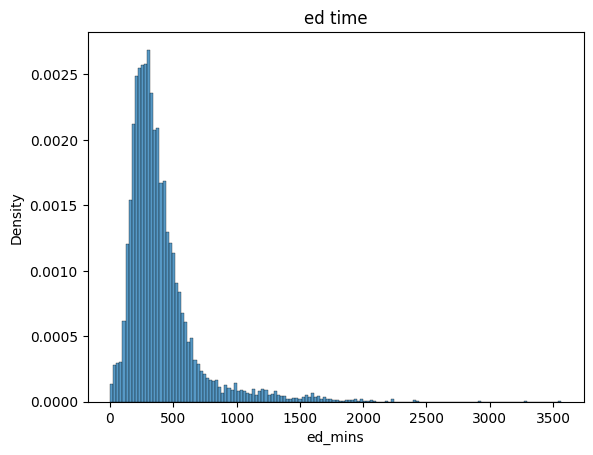

In [11]:
sns.histplot(x='ed_mins', data=ed, stat='density').set(title='ed time')

Data was broken into 2 sections for more accurate distributions. 
- 0-1000 minutes
- 1000-3500 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Each time is measured by a patient’s ED out time (which is often the same or close to admit time) and ED in time . The patients that do not take a value from the distribution have a 0 and their hospital arrival time is equal to their hospital admission.

### From 0 to 1000 minutes:
Models the main peak of values

<Axes: title={'center': 'ed time: 0 to 1000'}, xlabel='ed_mins', ylabel='Density'>

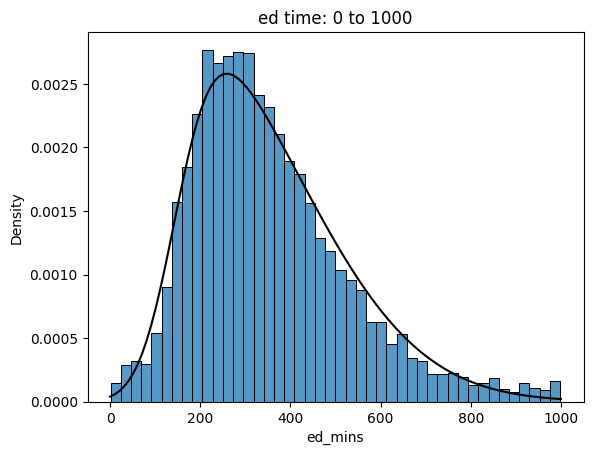

In [12]:
data=ed[ed['ed_mins']<1000]
a,loc, scale = stats.skewnorm.fit(data['ed_mins'])
x = np.linspace(0,1000, 100)
sns.histplot(x='ed_mins', data=data, stat='density').set(title='ed time: 0 to 1000')
sns.lineplot(x=x, y=stats.skewnorm.pdf(x, a,loc, scale), color='black')

- Graphed with a skewnorm distribution
- a = 4
- loc = 146.3
- scale = 269.8
- Out of all stroke patient ED stays, this distribution includes 95.6% of them

### From 1000 to 3500 minutes:
Models the decrease in frequency of values

<Axes: title={'center': 'ed time: 1000 to 3500'}, xlabel='ed_mins', ylabel='Density'>

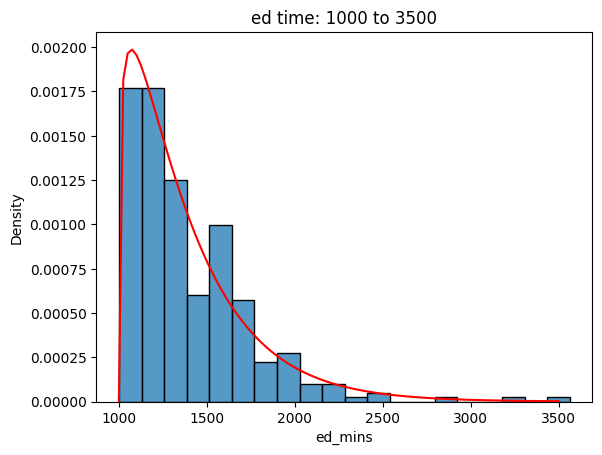

In [13]:
data2=ed[ed['ed_mins']>=1000]
a1,loc1, scale1 = stats.gamma.fit(data2['ed_mins'])
x = np.linspace(1000,3500, 100)
sns.histplot(x='ed_mins', data=data2, stat='density').set(title='ed time: 1000 to 3500')
sns.lineplot(x=x, y=stats.gamma.pdf(x, a1,loc1, scale1), color='red')

- Graphed using a gamma distribution
- a = 1.21
- loc = 1002.4
- scale = 320.2
- Out of all stroke patient ED visits, this distribution includes 4.4% of them

These two distributions include all ED stay times.

## Length of stay in the Neurology Ward

[Text(0.5, 1.0, 'neurology ward time')]

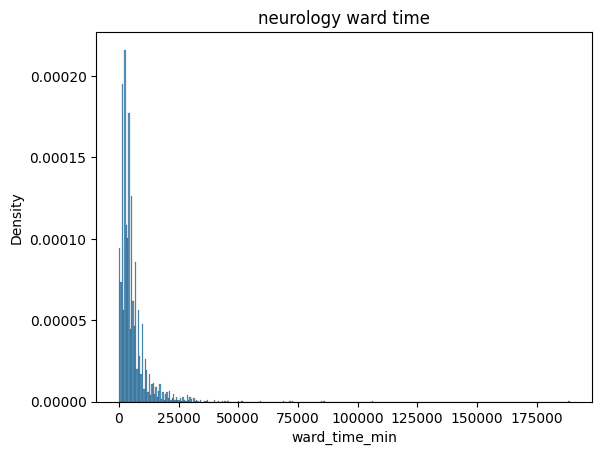

In [14]:
sns.histplot(x='ward_time_min', data=neuro, stat='density').set(title='neurology ward time')

Data was broken into 2 sections for more accurate results.
- 0-15000 minutes
- 15000-50000 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Each time is measured by a patient’s neurology out time and in time. 


### From 0 to 15000 minutes:
Models the main peak of results

<Axes: title={'center': 'neurology ward time: 0 to 15000'}, xlabel='ward_time_min', ylabel='Density'>

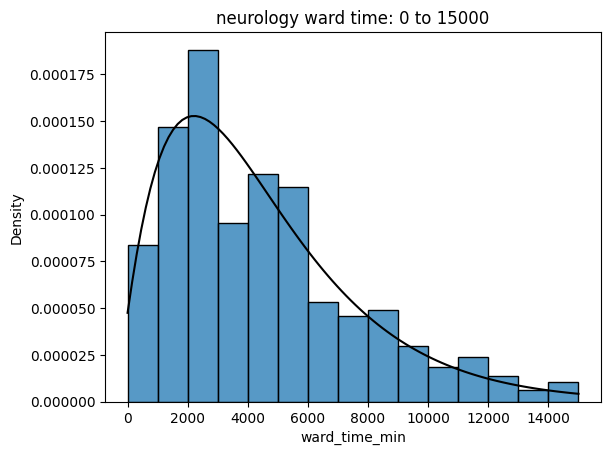

In [15]:
x = np.linspace(0,15000, 100)

data=neuro[neuro['ward_time_min'] < 15000]
a, loc, scale = stats.gamma.fit(data['ward_time_min'])

sns.histplot(x='ward_time_min', data=data, stat='density', bins=15).set(title='neurology ward time: 0 to 15000')
sns.lineplot(x=x, y=stats.gamma.pdf(x, a,loc, scale), color='black')

- Graphed using a gamma distribution
- a = 2.16
- loc = -410.2
- scale = 2262.7
- Of all the stroke patients in the neurology ward, this distribution includes 94.1% of them

### From 15000 to 50000:
Models the decrease in frequency of values

<Axes: title={'center': 'neurology ward time: 15000 to 50000'}, xlabel='ward_time_min', ylabel='Density'>

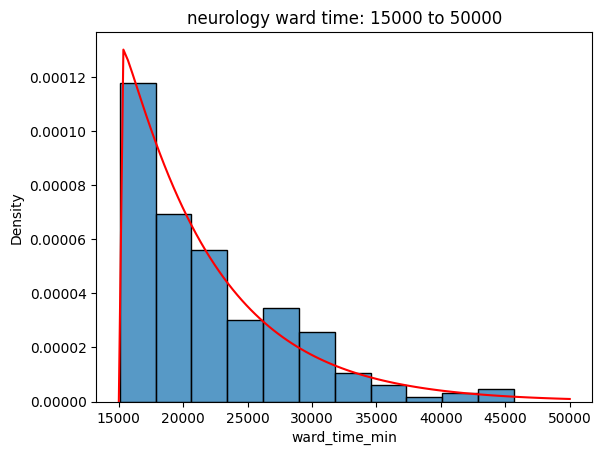

In [16]:
x2 = np.linspace(15000, 50000, 100)
data2 = neuro[neuro['ward_time_min'] > 15000]
data2 = data2[data2['ward_time_min']<50000]
a1, loc1, scale1 = stats.gamma.fit(data2['ward_time_min'])

sns.histplot(x='ward_time_min', data=data2, stat='density').set(title='neurology ward time: 15000 to 50000')
sns.lineplot(x=x2, y=stats.gamma.pdf(x2,a1, loc1, scale1), color='red')

- Graphed using a gamma distribution
- a = 1.026
- loc = 15065.1
- scale = 6889.8
- Of all the stroke patients in the neurology ward, this distribution includes 5.7% of them

There are 11 points outside of this range (ranging from 50000 and 200000), which are excluded to create a more accurate distribution for the rest of the values, so any extra percent from those points are assigned to this distribution. This does not affect the simulated results since it is such a small amount.

## Admission time to CT Scan and TPA

Due to dates being unprecise (only mesured to the day instead of time), CT scans and TPA treatments are scheduled on a normal distribution from hospital arrival. Values are chosen based on reasonable timings. Of the 9523 hospital checkins, there are 1586
CT scans (16.7%) and 384 (4%) TPA treatments, which is reprsented in the model.
#### For CT Scans:
- loc = 15
- scale = 5
#### For TPA:
- loc = 45
- scale = 5

## Admission time to ICU

Of the 9523 hospital checkins, there are 4274 ICU stays (44.9%), so 45% take a sample from this distribution to go to the ICU. The rest do not go to the ICU.

[Text(0.5, 1.0, 'time to icu')]

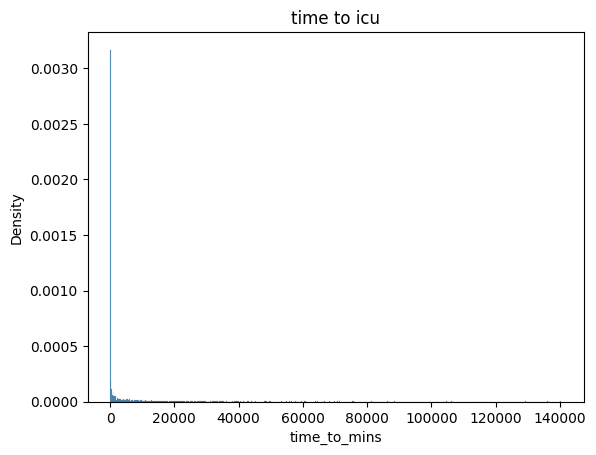

In [34]:
data = icu[icu['time_to_mins']>0]
sns.histplot(x='time_to_mins', data=data, stat='density').set(title='time to icu')

Data was broken into 3 sections for more accurate distributions:
- 1-4 minutes
- 4-200 minutes
- 200-80000 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Each time is measured by a patient’s ICU in time and hospital admit time.

There are 38 values less then 0 that are excluded, some could be due to a recording error or approximated time stamp. Since the majority of negative values are near zero, as well as the majority of positive values, the negative values were removed.

### From 1 to 4 minutes:
Models small, early peak in data

<Axes: title={'center': 'time to icu: 1 to 4'}, xlabel='time_to_mins', ylabel='Density'>

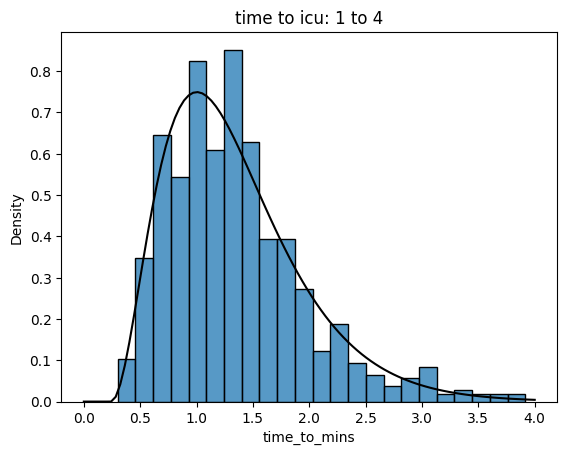

In [18]:
x = np.linspace(0,4,100)

data = icu[icu['time_to_mins']>0]
data = data[data['time_to_mins']<4]

a, loc, scale = stats.gamma.fit(data['time_to_mins'])
sns.histplot(x='time_to_mins', data=data, stat='density').set(title='time to icu: 1 to 4')
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='black')

- Graphed using a gamma distribution
- a = 3.23
- loc = 0.237
- scale = 0.343
- Of all the stroke patients in the ICU, this distribution includes 15.7% of them

### From 4 to 200 minutes:
Models main peak in the results

<Axes: title={'center': 'time to icu: 4 to 200'}, xlabel='time_to_mins', ylabel='Density'>

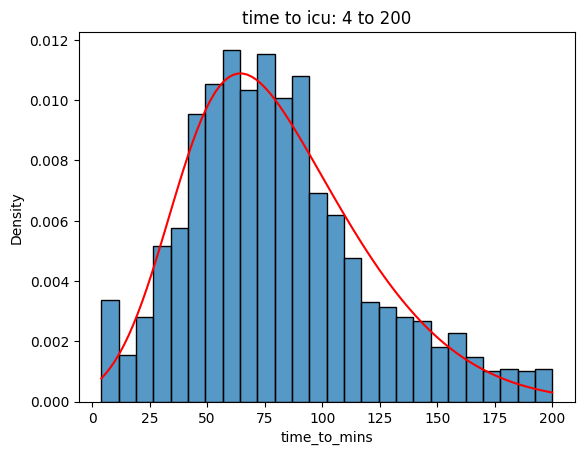

In [19]:
x2 = np.linspace(4,200,100)

data = icu[icu['time_to_mins']>4]
data2 = data[data['time_to_mins']<=200]

a2,loc2, scale2 = stats.skewnorm.fit(data2['time_to_mins'])

sns.histplot(x='time_to_mins', data=data2, stat='density').set(title='time to icu: 4 to 200')
sns.lineplot(x=x2, y=stats.skewnorm.pdf(x2, a2, loc2,scale2), color='red')

- Graphed using a skewnorm distribution
- a = 2.84
- loc = 35.6
- scale = 59.7
- Of all the stroke patients in the ICU this distribution includes 45.8% of them

### From 200 to 80000:

<Axes: title={'center': 'time to icu: 200 to 80000'}, xlabel='time_to_mins', ylabel='Density'>

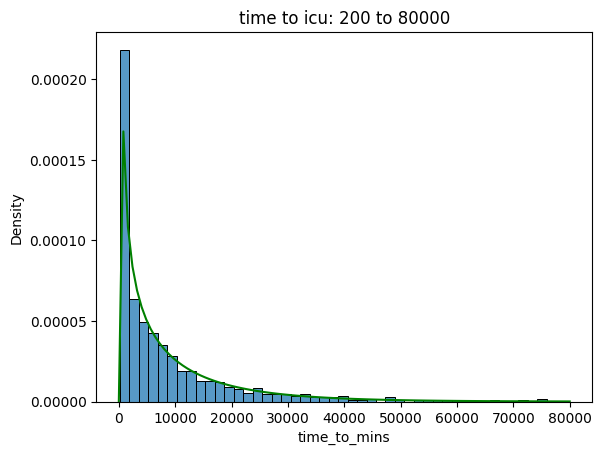

In [20]:
x = np.linspace(0,80000,100)

data = icu[icu['time_to_mins']>200]
data2 = data[data['time_to_mins']<=80000]

a, loc, scale = stats.gamma.fit(data2['time_to_mins'])

sns.histplot(x='time_to_mins', data=data2, stat='density').set(title='time to icu: 200 to 80000')
sns.lineplot(x=x, y=stats.gamma.pdf(x,a, loc, scale), color='green')

- Graphed using a gamma distribution
- a = 0.547
- loc = 201
- scale = 15138.3
- Of all the stroke patients in the ICU this distribution includes 37.2% of them

There are 15 points larger then the range of this distribution, however including those does not make any significant change to the distribution, so they are removed for more accurate results. Any extra percent for these values is included in this distribution

## Time to Neurology Ward

Split into two cases:
- From admission to neurology ward in time
- From ICU out time to neurology ward in time

Of the 9523 hospital check ins, there are 4192 neurology ward stays (44%). All patients that go to both the ICU and the neurology ward (in that order) have a neurology time based off of when they leave the ICU. The rest are based off of admission time.

## Admission time to Neurology Ward

<Axes: xlabel='first_admit_min', ylabel='Density'>

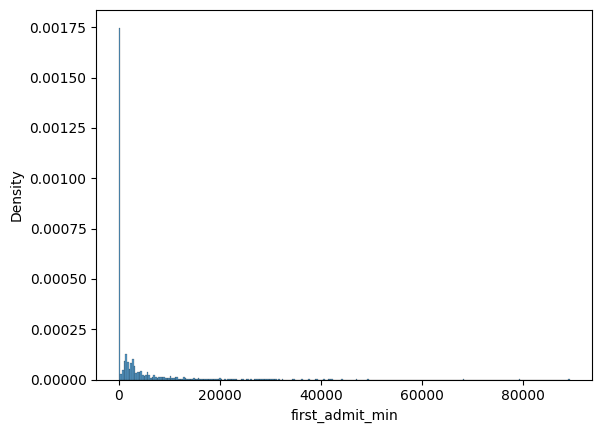

In [21]:
sns.histplot(x='first_admit_min', data=neuro, stat='density')

Data was broken into 4 sections for more accurate distributions:
- 0-3 minutes
- 3-200 minutes
- 200-10000 minutes
- 10000-40000 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. 

### From 0 to 3 minutes:
Models patients with almost immediate check in.

<Axes: title={'center': 'admit to neurology: 0 to 3 mins'}, xlabel='first_admit_min', ylabel='Density'>

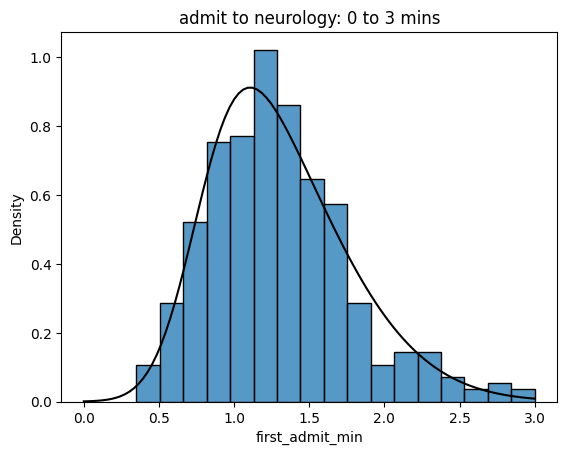

In [22]:
x = np.linspace(0,3, 100)
data=false[false['first_admit_min'] <= 3]
a,loc, scale = stats.skewnorm.fit(data['first_admit_min'])

sns.histplot(x='first_admit_min', data=data, stat='density').set(title='admit to neurology: 0 to 3 mins')
sns.lineplot(x=x, y=stats.skewnorm.pdf(x, a,loc, scale), color='black')

- Graphed using a skewnorm distribution
- a = 2.89
- loc = 0.762
- scale = 0.716
- Of the stroke patient neurology stays (who don't go to the ICU), this distribution includes 13.6%

### From 3 to 200 minutes:
Models second peak in times

<Axes: title={'center': 'admit to neurology: 3 to 200 mins'}, xlabel='first_admit_min', ylabel='Density'>

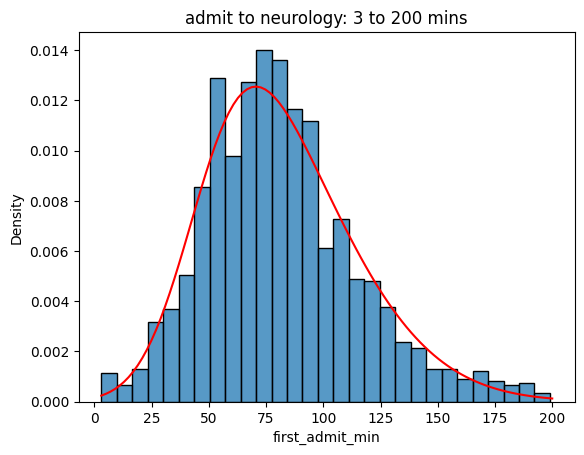

In [23]:
x2 = np.linspace(3, 200, 100)
data2 = false[false['first_admit_min'] > 3]
data2 = data2[data2['first_admit_min']<=200]
a2,loc2, scale2 = stats.skewnorm.fit(data2['first_admit_min'])

sns.histplot(x='first_admit_min', data=data2, stat='density').set(title='admit to neurology: 3 to 200 mins')
sns.lineplot(x=x2, y=stats.skewnorm.pdf(x2, a2,loc2, scale2), color='red')

- Graphed using a skewnorm distribution
- a = 2.38
- loc = 45.2
- scale = 49.6
- Of the stroke patient neurology stays (who don't go to the ICU), this distribution includes 68.8%

### From 200 to 10000:
Models third peak in data

<Axes: title={'center': 'admit to neurology: 200 to 10000'}, xlabel='first_admit_min', ylabel='Density'>

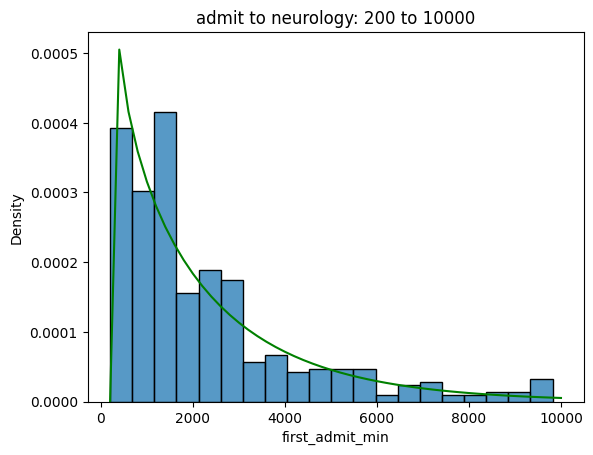

In [24]:
x3 = np.linspace(200,10000)
data3 = false[false['first_admit_min']>200]
data3 = data3[data3['first_admit_min']<=10000]
a3,loc3, scale3 = stats.gamma.fit(data3['first_admit_min'])

sns.histplot(x='first_admit_min', data=data3, stat='density').set(title='admit to neurology: 200 to 10000')
sns.lineplot(x=x3, y=stats.gamma.pdf(x3, a3,loc3, scale3), color='green')

- Graphed using a gamma distribution
- a = 0.84
- loc = 201.1
- scale = 2428.7
- Of the stroke patient neurology stays (who don't go to the ICU), this distribution includes 16.7%

### From 10000 to 40000 minutes:

<Axes: title={'center': 'admit to neurology: 10000 to 40000'}, xlabel='first_admit_min', ylabel='Density'>

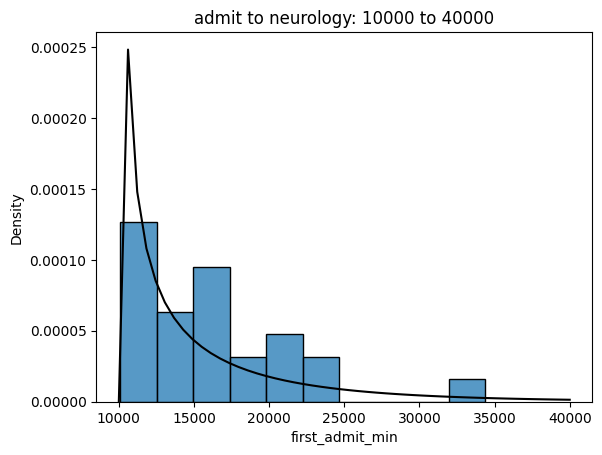

In [25]:
x4 = np.linspace(10000, 40000)
data4 = false[false['first_admit_min']>10000]
data4 = data4[data4['first_admit_min']<=40000]
a4,loc4, scale4 = stats.gamma.fit(data4['first_admit_min'])

sns.histplot(x='first_admit_min', data=data4, stat='density', bins=10).set(title='admit to neurology: 10000 to 40000')
sns.lineplot(x=x4, y=stats.gamma.pdf(x4,a4, loc4, scale4), color='black')

- Graphed using a gamma distribution
- a = 0.409
- loc = 10089.2
- scale = 10251.9
- Of all the stroke patient neurology stays, this distribution includes 1%

## ICU Time to Neurology Ward

Of the 4192 stroke neurology stays, 1365 of them have an ICU stay beforehand (32.6%) and are included in the category.

[Text(0.5, 1.0, 'icu to neurology')]

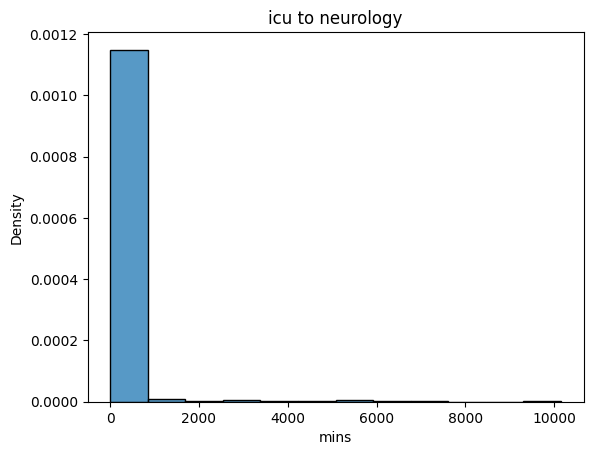

In [26]:
sns.histplot(x='mins', data=icu_neuro, stat='density').set(title='icu to neurology')

Data was broken into 2 groups for more accurate distributions:
- 0 minutes
- Greater then 0 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category.

### 0 minutes:
Most of the patients go immediately to the neurology ward after they check out of the ICU (96.1%). Any patient in this category has their neurology in time set equal to their ICU out time and the transition happens in the same step.

### Greater then 0 minutes:

[Text(0.5, 1.0, 'icu to neurology: > 0')]

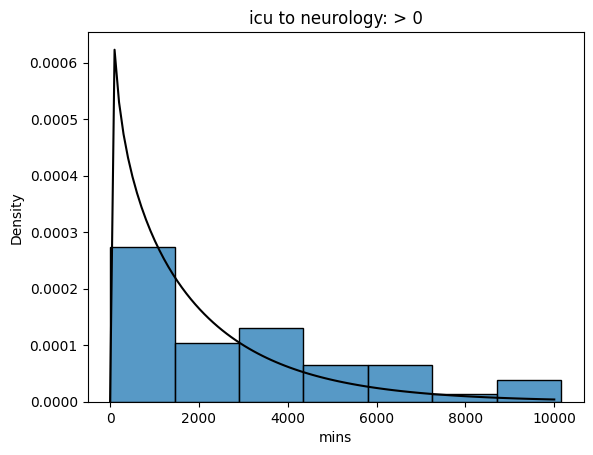

In [27]:
data = icu_neuro[icu_neuro['mins']>0]
x=np.linspace(0, 10000, 100)
a, loc, scale = stats.gamma.fit(data['mins'])

sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='black')
sns.histplot(x='mins', data=data, stat='density').set(title='icu to neurology: > 0')

- Graphed using a gamma distribution
- a = 0.832
- loc = 1.42
- scale = 2309.4
- Of all stroke patient neurology stays that come after an ICU stays, this distribution includes 3.9%

## Admission time to Specialists

Currently patients are only able to see each specialist once which should be updated to reflect true results.

## Physiotherapy

Of the 9523 hospital checkins, 7064 of those include a visit to a physiotherapist, so 74.2% take a sample from this distribution. The rest do not see a physiotherapist.

[Text(0.5, 1.0, 'admit to physio')]

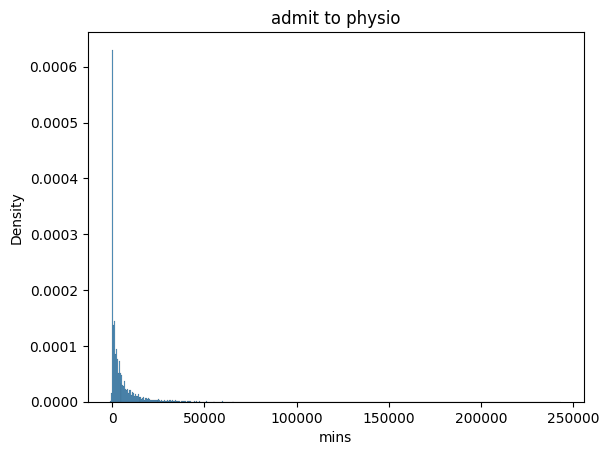

In [36]:
sns.histplot(x='mins', data=pt, stat='density').set(title='admit to physio')

Data was broken into 4 sections for more accurate distributions
- Less then 0
- 0-300 minutes
- 300-30000 minutes
- 30000-80000 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Most times are mesured from hospital admission to physiotherapy order time, and the rest from ED arrival.

### Less then 0:

Models data that happens before hospital admission (in ED or unexplained)

<Axes: title={'center': 'ed arrival to physio'}, xlabel='from_ed_mins', ylabel='Density'>

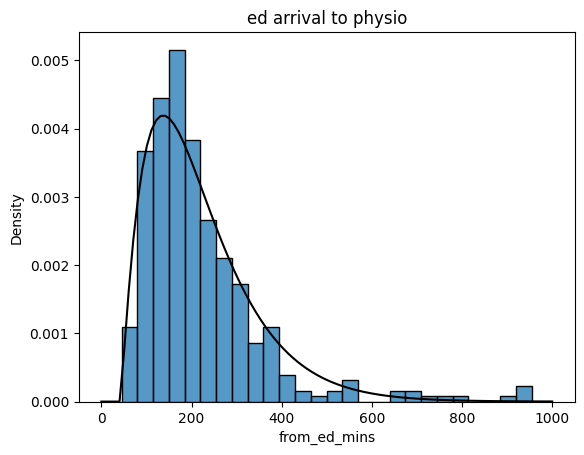

In [29]:
data = ng_pt[ng_pt['from_ed_mins']>=0]
data = data[data['from_ed_mins']<1000]
x = np.linspace(0, 1000, 100)
a, loc, scale = stats.gamma.fit(data.from_ed_mins)
sns.histplot(x='from_ed_mins', data=data, stat='density').set(title='ed arrival to physio')
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='black')

- Graphed using a gamma distribution
- a = 2.15
- loc = 42.2
- scale = 82.7
- Of the physiotherapy patients, this distribution includes 4.2% of them

This distribution represents the negative values in the physiotherapy consult data. Many of these negatives seem to be due to the consult taking place before hospital admission (in the Emergency Department), but some have no real explanation. Could be due to a recording error or a gap in the data. Since the majority (87% of negatives) are in the ED at the time of their consult, this is incorporated into the model. 

Patients in this distribution (if they are in the ED) sample a time from when they enter the ED. Patients who do not go to the ED in this percentage sample from the 0-300 minutes distribution. There are 6 points larger then the range of this distribution, but since 95% of patients spend under 1000 minutes in the Emergency Department, these points were removed to increase accuracy.

### From 0 to 300 minutes:

(5.906935658103551, -45.71340539492735, 28.004812718319933, 0.2773586754188302)

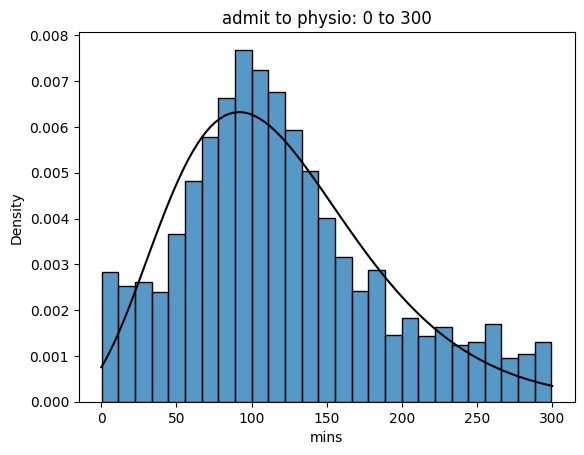

In [37]:
data = pt[pt['mins']>0]
data=data[data['mins']<300]

x = np.linspace(0,300,100)
a, loc, scale = stats.gamma.fit(data['mins'])
sns.histplot(x='mins', data=data, stat='density')
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='black').set(title='admit to physio: 0 to 300')
a, loc, scale, len(data)/len(pt)

- Graphed using a gamma distribution
- a = 5.91
- loc = -45.7
- scale = 28
- Of the physiotherapy patients, this distribution includes 27.7% of them

### From 300 to 30000 minutes: 

[Text(0.5, 1.0, 'admit to physio: 300 to 30000')]

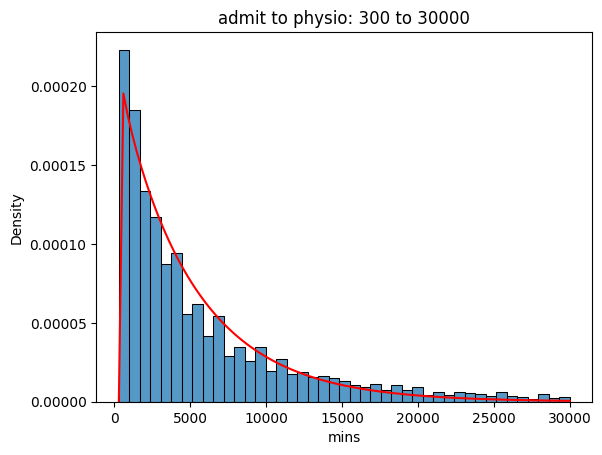

In [38]:
data = pt[pt['mins']>300]
data=data[data['mins']<30000]

x = np.linspace(300,30000,100)
a, loc, scale = stats.gamma.fit(data['mins'])
sns.histplot(x='mins', data=data, stat='density')
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='red').set(title='admit to physio: 300 to 30000')

- Graphed using a gamma distribution
- a = 0.973
- loc = 300.3
- scale = 5128.5
- Of the physiotherapy patients, this distribution includes 65.4% of them

### From 30000 to 80000 minutes:

[Text(0.5, 1.0, 'admit to physio: 30000 to 80000')]

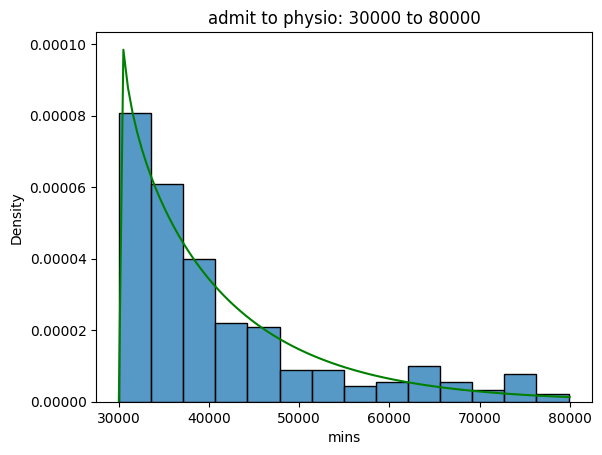

In [42]:
data = pt[pt['mins']>30000]
data=data[data['mins']<80000]

x = np.linspace(30000,80000,100)
a, loc, scale = stats.gamma.fit(data['mins'])
sns.histplot(x='mins', data=data, stat='density')
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='green').set(title='admit to physio: 30000 to 80000')

- Graphed using a gamma distribution
- a = 0.896
- loc = 30021.7
- scale = 12822.1
- Of the physiotherapy patients, this distribution includes 2.5% of them

There are 16 patients outside of this range (between 80000 and 250000) that are excluded for more accurate results. Any percent from those points is included in this distribution. This not does affect the simulated results since there is such a small amount.

## Occupational Therapist

Of 9523 hospital checkins, 4956 of those include a vist with a occupational therapist, so 52% take a sample from thie distribution. The rest do not see an occupational therapist.

[Text(0.5, 1.0, 'admit to ocu therapist')]

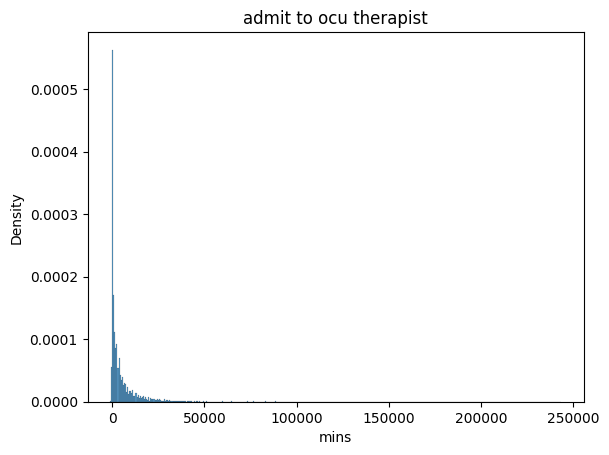

In [53]:
sns.histplot(x='mins', data=ocu, stat='density').set(title='admit to ocu therapist')

Data was broken into 3 sections for more accurate distributions
- 0-200 minutes
- 200-20000 minutes
- 20000-100000 minutes

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Times are mesured from hospital admission to occupational therapy order time.

## From 0 to 200 minutes:

[Text(0.5, 1.0, 'admit to ocu therapist: 0 to 200')]

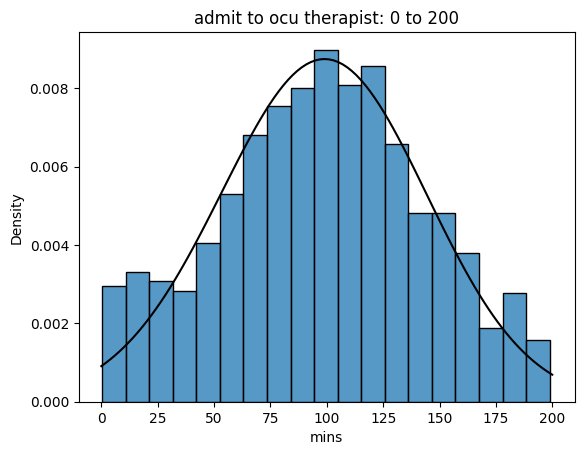

In [55]:
data = ocu[ocu['mins']<200]
data = data[data['mins']>0]
sns.histplot(x='mins', data=data, stat='density')
x = np.linspace(0,200,100)
a, loc, scale = stats.skewnorm.fit(data['mins'])
sns.lineplot(x=x, y=stats.skewnorm.pdf(x,a,loc,scale), color='black').set(title='admit to ocu therapist: 0 to 200')

- Graphed using a skewnorm distribution
- a = -0.66
- loc = 120.3
- scale = 51
- Of the occupational therapy  patients, this distribution includes 25.1% of them

Currently this distribution does not account for occupational therapy visits before hospital admit time.

### From 200 to 20000 minutes:

[Text(0.5, 1.0, 'admit to ocu therapist: 200 to 20000')]

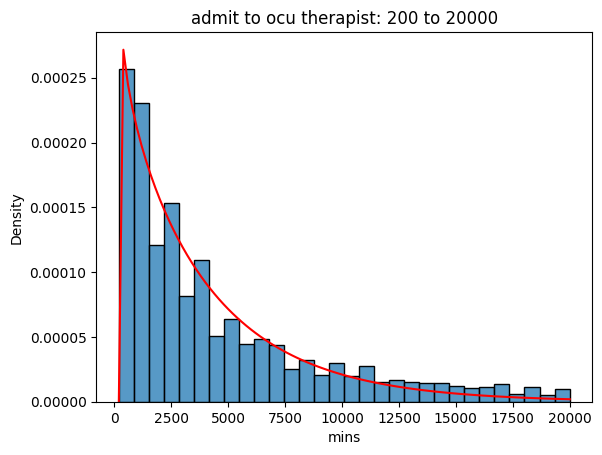

In [57]:
data = ocu[ocu['mins']<20000]
data = data[data['mins']>200]
sns.histplot(x='mins', data=data, stat='density')
x = np.linspace(200,20000,100)
a, loc, scale = stats.gamma.fit(data['mins'])
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='red').set(title='admit to ocu therapist: 200 to 20000')

- Graphed using a gamma distribution
- a = 0.918
- loc = 200.4
- scale = 4280.7
- Of the occupational therapy  patients, this distribution includes 64.5% of them

### From 20000 to 100000 minutes:

(0.8716604574542155,
 20007.816666666662,
 16391.179097443077,
 0.056854074542008845)

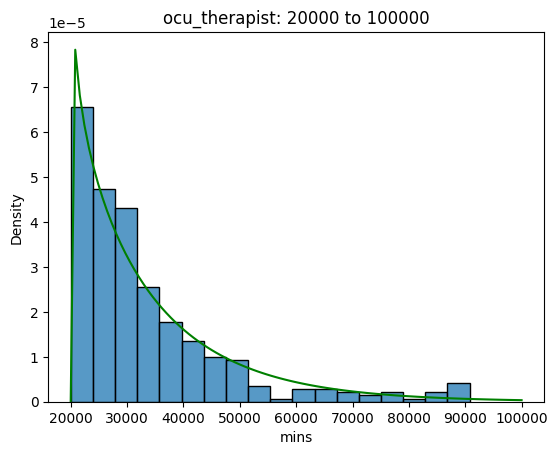

In [58]:
data = ocu[ocu['mins']<100000]
data = data[data['mins']>20000]
sns.histplot(x='mins', data=data, stat='density')
x = np.linspace(20000,100000,100)
a, loc, scale = stats.gamma.fit(data['mins'])
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='green').set(title='admit to ocu therapist: 20000 to 100000')
a, loc, scale, len(data)/len(ocu)

- Graphed using a gamma distribution
- a = 0.872
- loc = 20007.8
- scale = 16391.2
- Of the occupational therapy  patients, this distribution includes 5.7% of them

There are 10 patients (half of these are duplicates) outside of this range that are excluded for more accurate results. Any percent from those points is included in this distribution. This not does affect the simulated results since there is such a small amount.

## Social Worker
Of the 9523 hospital checkins, 1934 of them include a social worker visit, so 20.3% take a sample from this distribution. The rest do not see a social worker.

[Text(0.5, 1.0, 'admit to social work')]

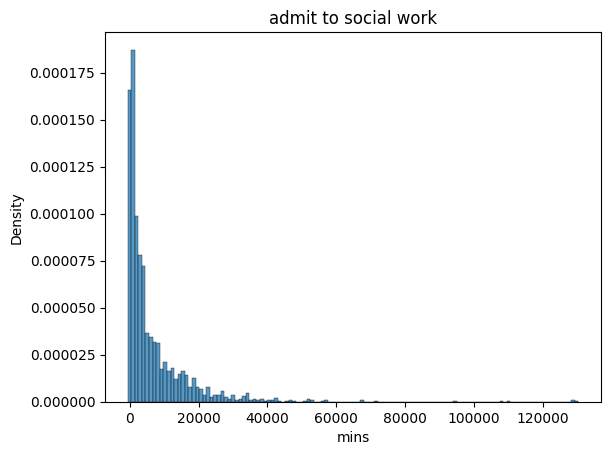

In [62]:
sns.histplot(x='mins', data=sw, stat='density').set(title='admit to social work')

Data was broken into 2 sections for more accuarte distributions
- 0-20000 minutes
- 20000-60000 minutes.

When choosing which distribution, a patient has a percent chance equal to the percent of patients in each category. Times are mesured from hospital admission to social work order time.

### From 0 to 20000 minutes:

[Text(0.5, 1.0, 'admit to social work: 0 to 20000')]

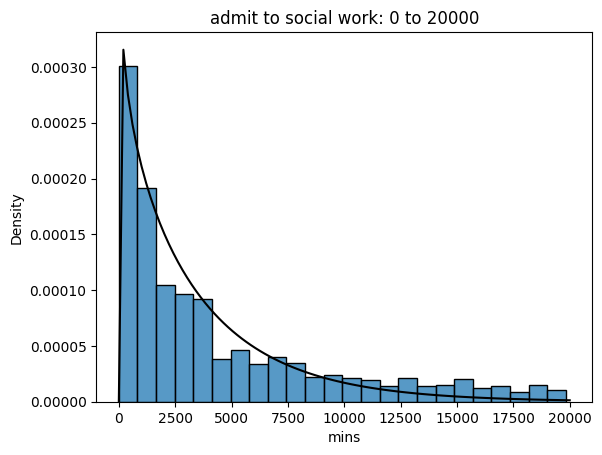

In [65]:
data = sw[sw['mins']<20000]
data = data[data['mins']>0]
sns.histplot(x='mins', data=data, stat='density')
a, loc, scale = stats.gamma.fit(data['mins'])
x = np.linspace(0, 20000, 100)
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='black').set(title='admit to social work: 0 to 20000')

- Graphed using a gamma distribution
- a = 0.874
- loc = 0.117
- scale = 4029.7
- Of the occupational therapy  patients, this distribution includes 91.5% of them

Currently this distribution does not account for social worker visits before hospital admit time, but any extra percent from those points is accounted for in this distribution.

### From 20000 to 60000 minutes:

(1.0256160206767755,
 20163.722484636004,
 9481.461324969896,
 0.06840974212034384)

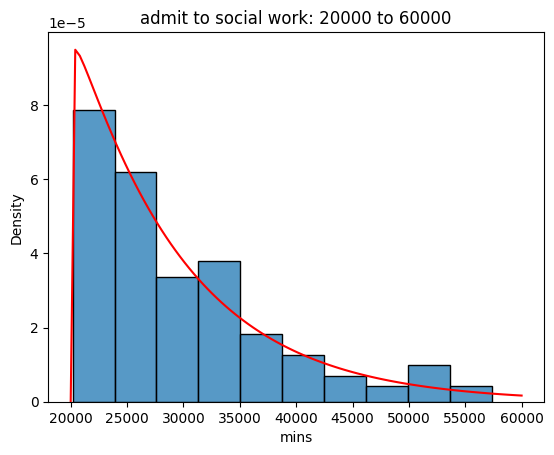

In [66]:
data = sw[sw['mins']<60000]
data = data[data['mins']>20000]
sns.histplot(x='mins', data=data, stat='density')
a, loc, scale = stats.gamma.fit(data['mins'])
x = np.linspace(20000, 60000,100)
sns.lineplot(x=x, y=stats.gamma.pdf(x,a,loc,scale), color='red').set(title='admit to social work: 20000 to 60000')
a, loc, scale, len(data)/len(sw)

- Graphed using a gamma distribution
- a = 1.026
- loc = 20163.7
- scale = 9481.5
- Of the occupational therapy  patients, this distribution includes 6.8% of them

There are 9 points outside of this range but they are excluded for more accurate results. This does not affect the simulated results.

## Dietitian

Of the 9523 hospital checkins, 1702 of those include a visit from a dietitian, so 17.9% take a sample from this distribution. The rest do not see a dietitian.